In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
breast_cancer_df = pd.read_csv("../data/raw/breast_cancer.csv")
breast_cancer_control_df = pd.read_csv("../data/raw/breast_cancer_controls.csv")

# Control matching with euclidean distance (greedy)

In [3]:
from tqdm import tnrange, tqdm, tqdm_notebook
from time import sleep
from scipy.spatial import distance

breast_cancer_control_df_copy = breast_cancer_control_df.copy()

selected_breast_cancer_patients_control_df = pd.DataFrame(index=np.arange(0, len(breast_cancer_df)), columns=breast_cancer_control_df.columns, dtype=breast_cancer_control_df.dtypes)

for i, row in tqdm_notebook(enumerate(breast_cancer_df.iterrows()), total=len(breast_cancer_df)):
    point = [row[1]['COUNT_CODES_BEFORE'], row[1]['MONTHS_CODES_BEFORE']]
    control_points = breast_cancer_control_df_copy[['COUNT_CODES', 'MONTHS_CODES']].values
    
    closest_control_point_index = distance.cdist([point], control_points).argmin()
    closest_control_point = control_points[closest_control_point_index]
    closest_control_row = breast_cancer_control_df_copy.iloc[closest_control_point_index]
        
    selected_breast_cancer_patients_control_df.loc[i] = closest_control_row
    breast_cancer_control_df_copy.drop(breast_cancer_control_df_copy.index[closest_control_point_index], inplace=True)

Widget Javascript not detected.  It may not be installed or enabled properly.


# Breast cancer patients

In [4]:
breast_cancer_df.describe()

,IND_SEQ,COUNT_BREAST_CANCER,COUNT_CODES_BEFORE,MONTHS_CODES_BEFORE
count,2.901000e+03,2901.000000,2901.000000,2901.000000
mean,1.421327e+06,64.500862,103.490521,98.794220
std,9.755745e+05,94.571413,148.141562,54.965151
min,1.225000e+03,3.000000,10.000000,24.032258
25%,6.230070e+05,6.000000,25.000000,54.451613
50%,1.301718e+06,26.000000,51.000000,89.096774
75%,1.985080e+06,84.000000,122.000000,131.290323
max,4.134375e+06,1036.000000,2242.000000,327.612903


# Control patients (after selection)

In [5]:
selected_breast_cancer_patients_control_df.describe()

,IND_SEQ,COUNT_CODES,MONTHS_CODES
count,2901.0,2901.0,2901.000000
unique,2901.0,440.0,2223.000000
top,2457598.0,10.0,60.741935
freq,1.0,64.0,5.000000


# Code counts

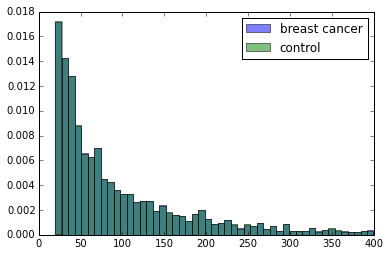

In [6]:
bins = np.linspace(20, 400, 50)

plt.hist(breast_cancer_df['COUNT_CODES_BEFORE'].values, bins, normed=True, alpha=0.5, label='breast cancer')
plt.hist(selected_breast_cancer_patients_control_df['COUNT_CODES'].values, bins, normed=True, alpha=0.5, label='control')
plt.legend(loc='upper right')
plt.show()

# Number of months

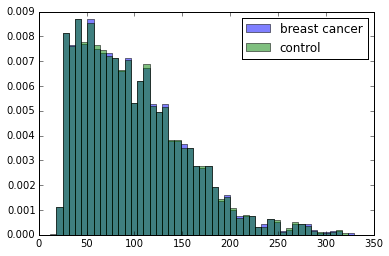

In [7]:
bins = np.linspace(12, 330, 50)

plt.hist(breast_cancer_df['MONTHS_CODES_BEFORE'].values, bins, normed=True, alpha=0.5, label='breast cancer')
plt.hist(selected_breast_cancer_patients_control_df['MONTHS_CODES'].values, bins, normed=True, alpha=0.5, label='control')
plt.legend(loc='upper right')
plt.show()

# Breast cancer vs. control

/Users/jacek/.pyenv/versions/3.5.0/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


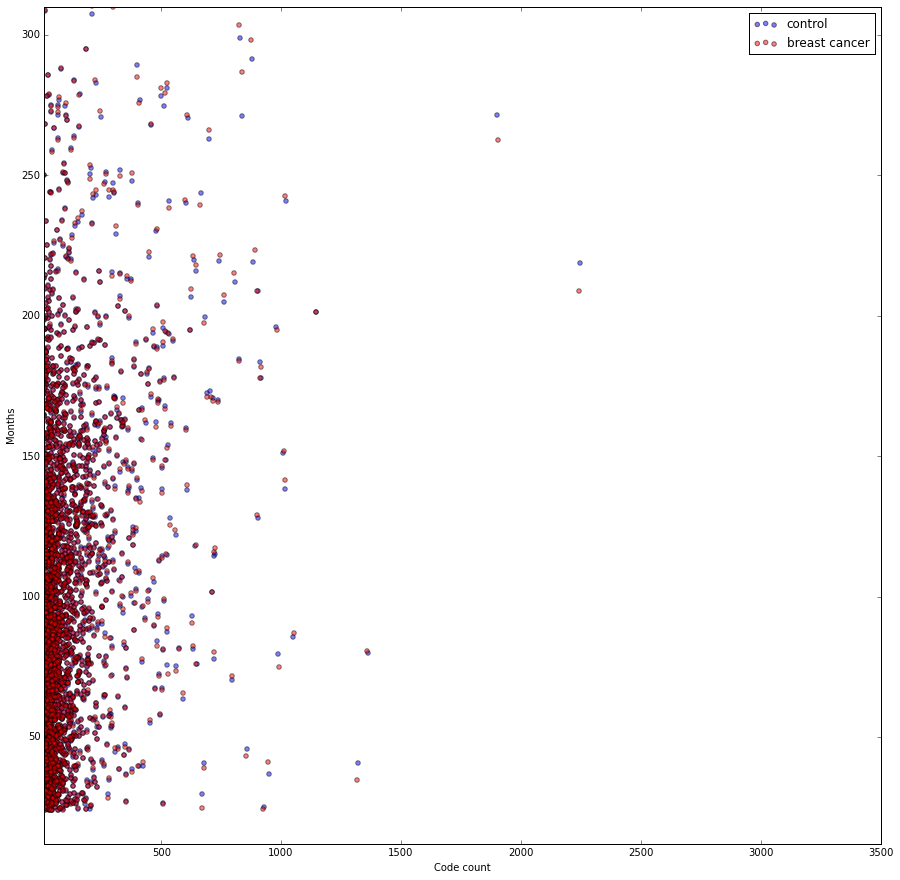

In [8]:
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

plt.scatter(selected_breast_cancer_patients_control_df['COUNT_CODES'].values, selected_breast_cancer_patients_control_df['MONTHS_CODES'].values, alpha=0.5, label='control')
plt.scatter(breast_cancer_df['COUNT_CODES_BEFORE'].values, breast_cancer_df['MONTHS_CODES_BEFORE'].values, c='red', alpha=0.5, label='breast cancer')
plt.legend(loc='upper right')
plt.xlim((10,3500))
plt.xlabel('Code count')
plt.ylim((12,310))
plt.ylabel('Months')
plt.show()

# Generate final patient list

In [9]:
import datetime

final_breast_cancer_patients_df = breast_cancer_df.rename(columns={
    'COUNT_CODES_BEFORE': 'COUNT_CODES', 
    'MONTHS_CODES_BEFORE': 'MONTHS_CODES',
    'FIRST_BREAST_CANCER': 'CUTOFF_DATE'})
final_breast_cancer_patients_df.drop(["COUNT_BREAST_CANCER"], axis=1, inplace=True)

selected_breast_cancer_patients_control_df["IND_SEQ"] = selected_breast_cancer_patients_control_df["IND_SEQ"].astype(int)
final_breast_cancer_patients_df["OUTCOME"] = np.ones(len(final_breast_cancer_patients_df), dtype=np.int)
selected_breast_cancer_patients_control_df["OUTCOME"] = np.zeros(len(selected_breast_cancer_patients_control_df), dtype=np.int)
selected_breast_cancer_patients_control_df["CUTOFF_DATE"] = [datetime.datetime.now().strftime("%Y-%m-%d")]*len(selected_breast_cancer_patients_control_df)

final_patient_list = pd.concat([final_breast_cancer_patients_df, selected_breast_cancer_patients_control_df], ignore_index=True)
final_patient_list.drop(["COUNT_CODES", "MONTHS_CODES"], axis=1, inplace=True)
final_patient_list.to_csv("../data/intermediate/patient_list.csv", index=False)